Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.
Выполнить задание 2 для трех моделей.

(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

(опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [29]:
import time
import numpy as np
import pandas as pd
import catboost as cb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gmean, rankdata

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from bayes_opt import BayesianOptimization

pd.set_option("display.max_columns", 30)

## Useful Functions

In [2]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "H:/PyProgects/gb_Competitive_Data_Analysis"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data


def cross_validation(model, X, y, cv, categorical = []):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    if categorical:
        X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


In [3]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    #X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    return X

## Base Tables

In [4]:
train = get_input("train.csv")
test = get_input("test.csv")

data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols


,application_number,target,name_contract_type
0,123687442,0.0,Cash
1,123597908,1.0,Cash


## client_profile

In [5]:
client_profile = get_input("client_profile.csv")
client_profile = create_client_profile_features(client_profile)
client_profile.head(n=2)

client_profile.csv: shape = 250000 rows, 24 cols


C:\Users\Kokorozaci\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,...,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,...,31.542056,18.399533,101.678502,174.306004,8.7153,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,...,23.155971,11.644456,NaN,NaN,NaN,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462


In [6]:
data = data.merge(
    client_profile, how="left", on="application_number"
)

## baseline

In [7]:
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

categorial = train.dtypes[train.dtypes == "object"].index
numerical = list(set(train.columns) - set(categorial))
train = train.replace(np.inf, np.nan)
train = train.replace(-np.inf, np.nan)

In [8]:
class TargetEncoding(BaseEstimator, TransformerMixin):

    def __init__(self,
                 alpha: float = 0,
                 folds: int = 5,
                ):
        self.folds = folds
        self.alpha = alpha
        self.features = None
        self.cv = None

    def fit(self, X, y=None):
        self.features = {}
        self.cv = KFold(
            n_splits=self.folds, shuffle=True, random_state=27
        )
        global_mean = np.mean(y)

        for fold_number, (train_idx, valid_idx) in enumerate(self.cv.split(X, y), start=1):
            x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
            y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

            data = pd.DataFrame({"feature": x_train, "target": y_train})
            data = data.groupby(["feature"])["target"].agg([np.mean, np.size])
            data = data.reset_index()
            score = data["mean"] * data["size"] + global_mean * self.alpha
            score = score / (data["size"] + self.alpha)
            
            self.features[f"fold_{fold_number}"] = {
                key: value for key, value in zip(data["feature"], score)
            }

        return self

    def transform(self, X, y=None):
        m = pd.DataFrame(self.features).mean(axis=1).to_dict()
        x_transformed = X.copy(deep=True)
        x_transformed = x_transformed.map(m)
        return x_transformed
#         check_is_fitted(self, "features")

        # TBD

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        x_transformed = X.copy(deep=True)

        for fold_number, (train_idx, valid_idx) in enumerate(self.cv.split(X, y), start=1):
            x_transformed.loc[valid_idx] = x_transformed.loc[valid_idx].map(
                self.features[f"fold_{fold_number}"]
            )
        return x_transformed

In [9]:
def xgboost_cross_validation(params, X, y, cv, categorical = []):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    if categorical:
        X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        dtrain = xgb.DMatrix(
            x_train, y_train
        )
        dvalid = xgb.DMatrix(
            x_valid, y_valid
        )

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            evals=[(dtrain, "dtrain"), (dvalid, "dvalid")],
            early_stopping_rounds=25,
            num_boost_round=1000,
            verbose_eval=10,
            maximize=True,
        )

        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


In [10]:
test = pd.get_dummies(test, columns=['gender', 'name_contract_type'], drop_first=True)
train = pd.get_dummies(train, columns=['gender', 'name_contract_type'], drop_first=True)

In [11]:
train['family_status'] = train['family_status'].replace('Unknown', 'Married')

In [12]:
test['family_status'] = test['family_status'].replace('Unknown', 'Married')

In [13]:
train = train.replace('XNA', np.NaN)
test = test.replace('XNA', np.NaN)

In [14]:
encoder = TargetEncoding(alpha=10)
for feature in ['family_status','education_level' ]:
    train[f'num_{feature}'] = encoder.fit_transform(train[feature], target).astype('float64')
    test[f'num_{feature}'] = encoder.transform(test[feature]).astype('float64')


In [15]:
train.drop(['family_status','education_level' ], axis=1, inplace=True)

In [16]:
test.drop(['family_status','education_level' ], axis=1, inplace=True)

In [17]:
train.head(3)

,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,...,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,gender_M,gender_XNA,name_contract_type_Credit Card,num_family_status,num_education_level
0,1.0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,...,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,1,0,0,0.075646,0.089577
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
2,0.0,135000.0,1006920.0,42660.0,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,...,5.958264,3562.9200,NaN,NaN,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803,0,0,0,0.075662,0.051487


## KFold

In [18]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 1196
}

cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

estimators_catboost, oof_preds_catboost = cross_validation(
    model=cb.CatBoostClassifier(**cb_params), X=train, y=target, cv=cv, categorical=[]
)

Thu Dec 17 18:18:12 2020, Cross-Validation, 110093 rows, 53 cols
0:	test: 0.6741588	test1: 0.6611205	best: 0.6611205 (0)	total: 94.1ms	remaining: 3m 8s
10:	test: 0.7013715	test1: 0.6942442	best: 0.6942442 (10)	total: 412ms	remaining: 1m 14s
20:	test: 0.7047137	test1: 0.6981966	best: 0.6987337 (19)	total: 717ms	remaining: 1m 7s
30:	test: 0.7057081	test1: 0.7000611	best: 0.7000611 (30)	total: 1.05s	remaining: 1m 6s
40:	test: 0.7073284	test1: 0.7015523	best: 0.7015523 (40)	total: 1.35s	remaining: 1m 4s
50:	test: 0.7073079	test1: 0.7015337	best: 0.7019804 (41)	total: 1.64s	remaining: 1m 2s
60:	test: 0.7086736	test1: 0.7023901	best: 0.7024835 (59)	total: 1.93s	remaining: 1m 1s
70:	test: 0.7087793	test1: 0.7022378	best: 0.7025855 (61)	total: 2.24s	remaining: 1m
80:	test: 0.7098747	test1: 0.7029206	best: 0.7029206 (80)	total: 2.56s	remaining: 1m
90:	test: 0.7104815	test1: 0.7031137	best: 0.7032149 (89)	total: 2.86s	remaining: 60s
100:	test: 0.7116635	test1: 0.7039145	best: 0.7040129 (98)	tota

In [19]:
oof_score = roc_auc_score(
    target, oof_preds_catboost
)
print(f"OOF-score = {round(oof_score, 5)}")
# [0.72194, 0.72659, 0.73283, 0.72053, 0.72657]
# OOF-score = 0.72481

# OOF-score = 0.7243

# [0.72087, 0.727, 0.73241, 0.72158, 0.72649
# OOF-score = 0.72487

OOF-score = 0.72346


## Подготовка прогноза

In [21]:
y_pred = np.zeros(test.shape[0])
test[numerical] = test[numerical].astype(float)

for estimator in estimators_catboost:
    y_pred += estimator.predict_proba(test)[:, 1]

In [ ]:
y_pred = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred / cv.n_splits
})
y_pred.to_csv("4_catboost_pred.csv", index=False)

In [30]:
xgb_params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}



cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

estimators_xgboost, oof_preds_xgboost = xgboost_cross_validation(
    params=xgb_params, X=train, y=target, cv=cv, categorical=[]
)


Thu Dec 17 22:14:57 2020, Cross-Validation, 110093 rows, 53 cols
[22:14:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	dtrain-auc:0.60388	dvalid-auc:0.59538
Multiple eval metrics have been passed: 'dvalid-auc' will be used for early stopping.

Will train until dvalid-auc hasn't improved in 25 rounds.
[10]	dtrain-auc:0.68845	dvalid-auc:0.67914
[20]	dtrain-auc:0.69611	dvalid-auc:0.68767
[30]	dtrain-auc:0.71057	dvalid-auc:0.69971
[40]	dtrain-auc:0.71956	dvalid-auc:0.70664
[50]	dtrain-auc:0.72741	dvalid-auc:0.71213
[60]	dtrain-auc:0.73116	dvalid-auc:0.71542
[70]	dtrain-auc:0.73434	dvalid-auc:0.71703
[80]	dtrain-auc:0.73613	dvalid-auc:0.71841
[90]	dtrain-au

In [31]:
oof_score = roc_auc_score(
    target, oof_preds_xgboost
)
print(f"OOF-score = {round(oof_score, 5)}")

# [0.71841, 0.72408, 0.73208, 0.71992, 0.72015]
# OOF-score = 0.72236

OOF-score = 0.72236


In [32]:
import lightgbm as lgb

In [33]:

lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 2000,
    'metric': 'auc',
    'learning_rate': 0.05134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'early_stopping_round': 25,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 1196,
    'silent': -1,
    'verbosity': 10
}

model = lgb.LGBMClassifier(**lgbm_params)
cv = KFold(n_splits=5, random_state=1196, shuffle=True)

estimators_lgbm, oof_preds_lgbm = cross_validation(
    model=model, X=train, y=target, cv=cv, categorical=[]
)


Thu Dec 17 22:16:05 2020, Cross-Validation, 110093 rows, 53 cols


C:\Users\Kokorozaci\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7167, number of negative: 80907
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.746321
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.212942
[LightGBM] [Debug] init for col-wise cost 0.004334 seconds, init for row-wise cost 0.021601 seconds
[LightGBM] [Debug] col-wise cost 0.001223 seconds, row-wise cost 0.001341 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9011
[LightGBM] [Info] Number of data points in the train set: 88074, number of used features: 52
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081375 -> initscore=-2.423813
[LightGBM] [Info] Start training from score -2.423813
[Ligh

C:\Users\Kokorozaci\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7048, number of negative: 81026
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.746577
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.212927
[LightGBM] [Debug] init for col-wise cost 0.004568 seconds, init for row-wise cost 0.025654 seconds
[LightGBM] [Debug] col-wise cost 0.001135 seconds, row-wise cost 0.001188 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9020
[LightGBM] [Info] Number of data points in the train set: 88074, number of used features: 52
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080024 -> initscore=-2.442026
[LightGBM] [Info] Start training from score -2.442026
[Ligh

C:\Users\Kokorozaci\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7121, number of negative: 80953
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.746832
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.212885
[LightGBM] [Debug] init for col-wise cost 0.003663 seconds, init for row-wise cost 0.027116 seconds
[LightGBM] [Debug] col-wise cost 0.001046 seconds, row-wise cost 0.001196 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9007
[LightGBM] [Info] Number of data points in the train set: 88074, number of used features: 52
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080852 -> initscore=-2.430821
[LightGBM] [Info] Start training from score -2.430821
[Ligh

C:\Users\Kokorozaci\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7098, number of negative: 80977
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.745293
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.212586
[LightGBM] [Debug] init for col-wise cost 0.004022 seconds, init for row-wise cost 0.022537 seconds
[LightGBM] [Debug] col-wise cost 0.001216 seconds, row-wise cost 0.001278 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9017
[LightGBM] [Info] Number of data points in the train set: 88075, number of used features: 52
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080590 -> initscore=-2.434352
[LightGBM] [Info] Start training from score -2.434352
[Ligh

C:\Users\Kokorozaci\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7154, number of negative: 80921
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.745770
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.212768
[LightGBM] [Debug] init for col-wise cost 0.004094 seconds, init for row-wise cost 0.026574 seconds
[LightGBM] [Debug] col-wise cost 0.001193 seconds, row-wise cost 0.001228 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9013
[LightGBM] [Info] Number of data points in the train set: 88075, number of used features: 52
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081226 -> initscore=-2.425802
[LightGBM] [Info] Start training from score -2.425802
[Ligh

In [34]:
oof_score = roc_auc_score(
    target, oof_preds_lgbm
)
print(f"OOF-score = {round(oof_score, 5)}")

# [0.72054, 0.73403, 0.73157, 0.72308, 0.72681]
# OOF-score = 0.72625

OOF-score = 0.72625


In [ ]:
clf = RandomForestClassifier(max_depth=15, min_samples_leaf=5, random_state=0)

cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

estimators_rf, oof_preds_rf = logreg_cross_validation(
    model=clf, X=train.replace(np.inf, np.NaN).fillna(-9999), y=target, cv=cv, categorical=[]
)

Thu Dec 17 23:43:56 2020, Cross-Validation, 110093 rows, 53 cols


In [35]:
scores = pd.DataFrame({
    "lgbm": oof_preds_lgbm,
    "xgboost": oof_preds_xgboost,
    "catboost": oof_preds_catboost
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [69]:
scores_2 = pd.DataFrame({
    "lgbm": oof_preds_lgbm,
    "xgboost": oof_preds_xgboost
    
})

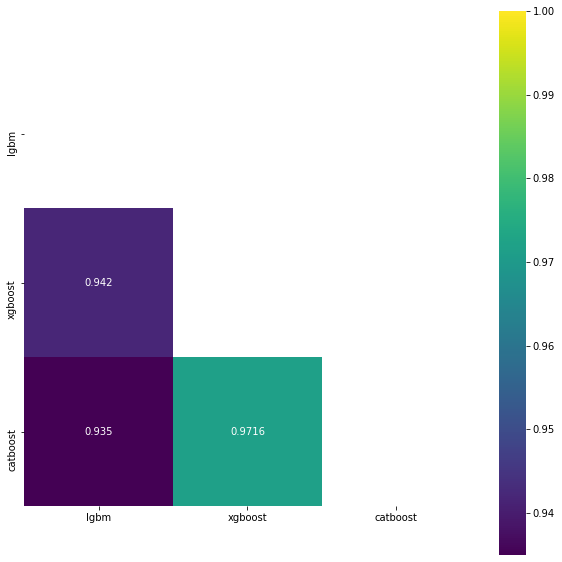

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [37]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")


Score = 0.7264


In [70]:
scores_mean = scores_2.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")


Score = 0.7266


In [38]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7264


In [71]:
scores_mean = gmean(scores_2, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7266


In [66]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7261


In [72]:
# ROC-AUC / GINI
scores_mean = scores_2.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7261


In [40]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7261


In [41]:
y_pred = np.zeros(test.shape[0])
test[numerical] = test[numerical].astype(float)

for estimator in estimators_catboost:
    y_pred += estimator.predict_proba(test)[:, 1]

In [42]:
y_pred_2 = np.zeros(test.shape[0])
test[numerical] = test[numerical].astype(float)

for estimator in estimators_lgbm:
    y_pred_2 += estimator.predict_proba(test)[:, 1]

In [43]:
y_pred_3 = np.zeros(test.shape[0])

dtest = xgb.DMatrix(
            test
        )

for estimator in estimators_xgboost:
    y_pred_3 += estimator.predict(dtest)

In [44]:
scores_test = pd.DataFrame({
    "1": y_pred,
    "2": y_pred_2,
    "3": y_pred_3
    
})

corr = scores_test.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [73]:
scores_test_2 = pd.DataFrame({
    "2": y_pred_2,
    "3": y_pred_3
    
})

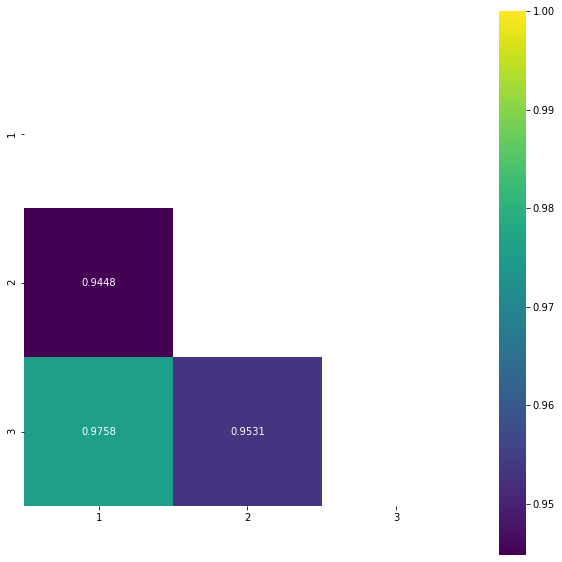

In [45]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [46]:
scores_mean = (scores_test/ cv.n_splits).mean(axis=1)
# 0.72867

In [74]:
scores_mean_2 = (scores_test_2/ cv.n_splits).mean(axis=1)
# 0.72866

In [47]:
scores_mean_g = gmean((scores_test/ cv.n_splits), axis=1)
# 0.72864

In [52]:
# ROC-AUC / GINI
scores_mean_r = (scores_test.rank()/ cv.n_splits).mean(axis=1)

In [53]:
scores_mean_r_g = gmean((scores_test.rank()/ cv.n_splits), axis=1)

In [75]:
y_pred = pd.DataFrame(data={"APPLICATION_NUMBER": np.array(test_id),
    "TARGET": scores_mean_2})
y_pred.to_csv("scores_mean_2_pred.csv", index=False)

In [76]:
from sklearn.linear_model import LogisticRegression

In [77]:
train_2 = pd.DataFrame({
    "lgbm": oof_preds_lgbm,
    "xgboost": oof_preds_xgboost,
    "catboost": oof_preds_catboost
    
})

In [84]:
clf = LogisticRegression(random_state=1196, penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=1000).fit(train_2, target)

In [85]:
scores_logreg = clf.predict_proba(scores_test/5)[:,1]

In [86]:
y_pred = pd.DataFrame(data={"APPLICATION_NUMBER": np.array(test_id),
    "TARGET": scores_logreg})
y_pred.to_csv("logreg_pred.csv", index=False)

# 0.72748 0.72725

In [89]:
cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

estimators_logreg, oof_preds_logreg = logreg_cross_validation(
    model=LogisticRegression(random_state=1196, penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=1000), X=train_2, y=target, cv=cv, categorical=[]
)

Thu Dec 17 23:31:27 2020, Cross-Validation, 110093 rows, 3 cols
Fold 1, Valid score = 0.72117
Fold 2, Valid score = 0.72838
Fold 3, Valid score = 0.73412
Fold 4, Valid score = 0.72325
Fold 5, Valid score = 0.72926
Score by each fold: [0.72117, 0.72838, 0.73412, 0.72325, 0.72926]


In [88]:
def logreg_cross_validation(model, X, y, cv, categorical = []):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    if categorical:
        X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model.fit(
            x_train, y_train)
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


In [90]:
oof_score = roc_auc_score(
    target, oof_preds_logreg
)
print(f"OOF-score = {round(oof_score, 5)}")

# [0.72117, 0.72838, 0.73412, 0.72325, 0.72926]
# OOF-score = 0.72661

OOF-score = 0.72661


In [92]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
clf = RandomForestClassifier(max_depth=6, min_samples_leaf=5, random_state=0)

cv = KFold(n_splits=5, random_state=1234123, shuffle=True)

estimators_logreg, oof_preds_logreg = logreg_cross_validation(
    model=clf, X=train_2, y=target, cv=cv, categorical=[]
)

Thu Dec 17 23:39:24 2020, Cross-Validation, 110093 rows, 3 cols
Fold 1, Valid score = 0.72228
Fold 2, Valid score = 0.72619
Fold 3, Valid score = 0.73325
Fold 4, Valid score = 0.72264
Fold 5, Valid score = 0.72811
Score by each fold: [0.72228, 0.72619, 0.73325, 0.72264, 0.72811]


In [100]:
oof_score = roc_auc_score(
    target, oof_preds_logreg
)
print(f"OOF-score = {round(oof_score, 5)}")
# OOF-score = 0.7258

OOF-score = 0.7258
